In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mag_inv import setup_data, setup_mesh, get_simulation, run_inversion
import pyvista as pv
pv.set_jupyter_backend('trame')

This notebook runs a simple magnetics inversion of the data provided. It does most of the work in setting up an inversion (using SimPEG) and running it. Most of your time will be spent playing and learning how to visualize the recoverd model in 3D to help support your interpretation.

In [2]:
data_mag = setup_data('data/Lab13_data.csv')
data_mag.nD

961

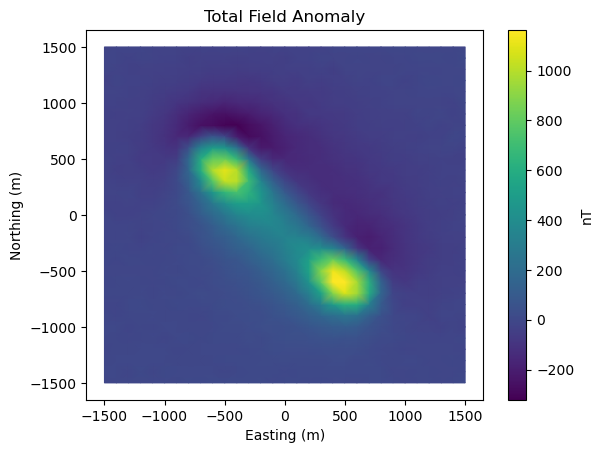

In [43]:
# let's plot up the data:
data_loc = data_mag.survey.receiver_locations
plt.tripcolor(data_loc[:, 0], data_loc[:, 1], data_mag.dobs, shading='gouraud')
plt.title('Total Field Anomaly')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
cb = plt.colorbar()
cb.set_label('nT')

In [3]:
# this is a 3D discretize.TreeMesh
mesh = setup_mesh(data_mag.survey, dh=50)
mesh

OcTreeMesh: 0.35% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  2   :       12             ---------------------------   --------------------
  3   :       112         x:    -6400.0   ,   6400.0          50.0   ,   3200.0  
  4   :       228         y:    -6400.0   ,   6400.0          50.0   ,   3200.0  
  5   :       720         z:    -3200.0   ,     0.0           25.0   ,   1600.0  
  6   :      3108      
  7   :      6620      
  8   :      18464     
-----------------------
Total :      29264

In [7]:
# setup simulation
sim = get_simulation(mesh, data_mag.survey)

In [13]:
model = run_inversion(
    data_mag,
    sim,
)


                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.56e+04  3.01e+08  1.65e+08  4.21e+12    8.55e+01      0              
   1  5.11e+03  7.37e+05  1.30e-02  7.37e+05    7.09e+01      0              
   2  1.02e+03  7.34e+05  3.23e-01  7.35e+05    7.06e+01      0              
   3  2.04e+02  7.22e+05  7.80e+00  7.23e+05    7.08e+01      0   Skip BFGS  
   4  4.09e+01  6.66e+05  1.67e+02  6.73e+05    7.44e+01      0   Skip BFGS  
   5  8.18e+00  4.94e+05  2.48e+03  5.15e+05    9.16e+01      0   Skip BFGS  
   6  1.64e+00  2.20e+05  1.93e+04  2.51e+05    1.14e+02      

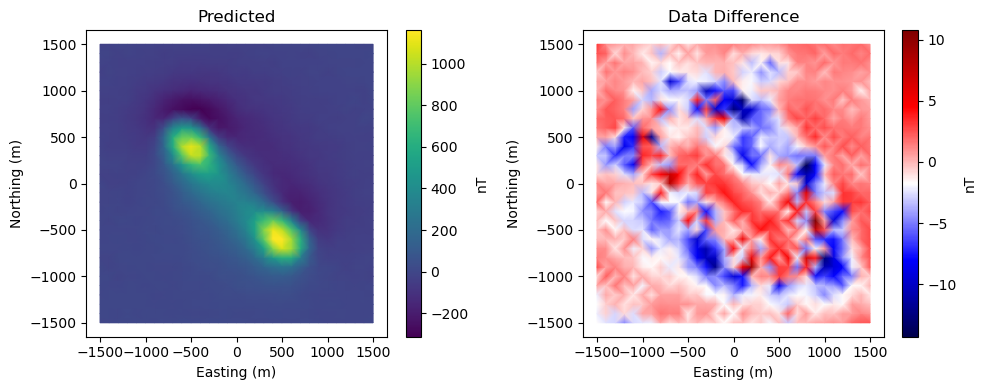

In [46]:
# Plot up the predicted data set:
dpred = sim.dpred(model)

# here we plot both the predicted and the difference between the predicted and observed data.
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.tripcolor(data_loc[:, 0], data_loc[:, 1], dpred, shading='gouraud')
plt.title('Predicted')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
cb = plt.colorbar()
cb.set_label('nT')

plt.subplot(1,2,2)
plt.title('Data Difference')
plt.tripcolor(data_loc[:, 0], data_loc[:, 1], data_mag.dobs - dpred, shading='gouraud', cmap='seismic')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
cb = plt.colorbar()
cb.set_label('nT')

plt.tight_layout()

# Simple visualization:
The tree mesh itself has some simple visualization capabilities for plotting slices normal to certain axes.

For instance, here is a horizontal slice (normal = z) at -100 m elevation, we also clip the x and y axes to be in the domain of the data to remove the padding cells from the plot

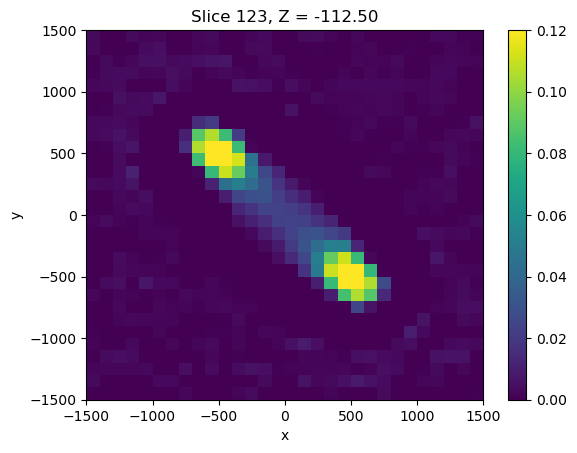

In [23]:
ax = plt.subplot(111)
im, = mesh.plot_slice(model, slice_loc=-100, normal='z', clim=[0, 0.12], ax=ax)
ax.set_xlim([-1500, 1500])
ax.set_ylim([-1500, 1500])
plt.colorbar(im)

Try out some more simple plots with different orientations and locations yourself to try to get an understanding of the 3D model.

# 3D plotting
Next let's use a python package called `pyvista` to get a 3D visualization of the model.
It uses a package called the Visualization Tool Kit to generate interactive images.

The first step is to convert the `discretize.TreeMesh` into a `pyvista` mesh, fortunately these packages interact well with each other and you can do this simply:

In [24]:
pv_mesh = mesh.to_vtk(models={'chi':model})
pv_mesh.set_active_scalars('chi')

(<FieldAssociation.CELL: 1>,
 pyvista_ndarray([0.00145662, 0.00141586, 0.00194028, ..., 0.00045244,
                  0.00075252, 0.0008191 ]))

Like the simple plotting, we usually would like to extract the core region of the mesh.
Like above, lets cutout the core region bounded by the data, with about 1000m depth.

In [25]:
# first let's cutout the padding zones
core = pv_mesh.clip_box(bounds=[-1500, 1500, -1500,1500, -1000, 0], invert=False)

In [28]:
# play around with the 3D plot of the core region to grasp the controls.
core.plot(clim=[0,0.12])

Widget(value="<iframe src='http://localhost:58782/index.html?ui=P_0x7f923225c2e0_1&reconnect=auto' style='widt…

`pyvista` has many ways to manipulate and "filter" meshes to create your image, for example
you can slice through your model with any plane orientation you like!

In [29]:
# plot a diagonal slice through the center of the model
slice = core.slice(normal=[1, 1, 0], origin=[0,0,0])
slice.plot(jupyter_backend='trame', clim=[0,0.12])

Widget(value="<iframe src='http://localhost:58782/index.html?ui=P_0x7f923225d180_2&reconnect=auto' style='widt…

Or let's say you want to threshold your model, and only show cells above a certain value.

In [30]:
thresh = pv_mesh.threshold(0.035)
thresh.plot(jupyter_backend='trame', clim=[0,0.12])

Widget(value="<iframe src='http://localhost:58782/index.html?ui=P_0x7f923225dcc0_3&reconnect=auto' style='widt…

What if I want to plot a slice and a threshold at the same time? Then we can make a block of all our meshes!

In [32]:
blocks = pv.MultiBlock([thresh, slice])
blocks.plot(clim=[0,0.12])

Widget(value="<iframe src='http://localhost:58782/index.html?ui=P_0x7f921ee06f80_5&reconnect=auto' style='widt…

In [37]:
# or make multiple slices!

slices = []
normal = np.array([1, 1, 0])
origin = np.array([0, 0, 0])
for offset in np.linspace(-1000, 1000, 5):
    slices.append(core.slice(normal=normal, origin=origin + offset*normal))

blocks = pv.MultiBlock(slices)
blocks.plot(clim=[0,0.12])

Widget(value="<iframe src='http://localhost:58782/index.html?ui=P_0x7f921e4882b0_7&reconnect=auto' style='widt…